In [ ]:
# univariate LSTM example
# https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

import datetime
import statistics as stats
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

%load_ext google.colab.data_table

In [ ]:
SCREEN_X, SCREEN_Y = 12, 8

def CryptoData(symbol, frequency, start=0):
    #Params: String symbol, int frequency = 300,900,1800,7200,14400,86400
    #Returns: df from first available date
    url ='https://poloniex.com/public?command=returnChartData&currencyPair='+symbol+'&end=9999999999&period='+str(frequency)+'&start='+str(start)
    df = pd.read_json(url)
    df.set_index('date',inplace=True)
    return df

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


def getPrediction(lstm, raw_seq, index, n_steps, n_features):
  x_seq = raw_seq[index-n_steps : index]
  x_seq = x_seq.reshape(1, n_steps, n_features)
  
  yhat = lstm.predict(x_seq)
  y = raw_seq[index]
  
  return x_seq, yhat, y


# predict the next day close as the same as today's close 
def getBasePrediction(raw_seq, index, n_steps):
  x_seq = raw_seq[index-n_steps : index]
  
  yhat = x_seq[len(x_seq)-1]
  y = raw_seq[index]
  
  return x_seq, yhat, y


def roundNum(num, dp=2):
	return round(num, dp)

In [ ]:
startDate = int((datetime.datetime.strptime('1/1/2018', "%d/%m/%Y").timestamp()))
testSymbol = 'USDT_BTC' #bitCoin
# frequency = 86400s which is 1 day
df = CryptoData(testSymbol, 86400, startDate)
df

In [ ]:
df['close'].plot(figsize = (SCREEN_X, SCREEN_Y))

In [ ]:
# define input sequence and no. of features
# Use only the "close" price as the input feature
raw_seq = df['close'].values
n_features = raw_seq.ndim
data_size = len(raw_seq)

print("n_features:", n_features) 
print("data_size:", data_size)

In [ ]:
# split the data into training and test set according to the date
# the earlier period is the training set
train_ratio = 0.8
train_size = round(train_ratio * data_size)
train_seq = raw_seq[:train_size]
test_seq = raw_seq[train_size:]

print("train_size:", train_size)
print("test_size:", data_size-train_size)

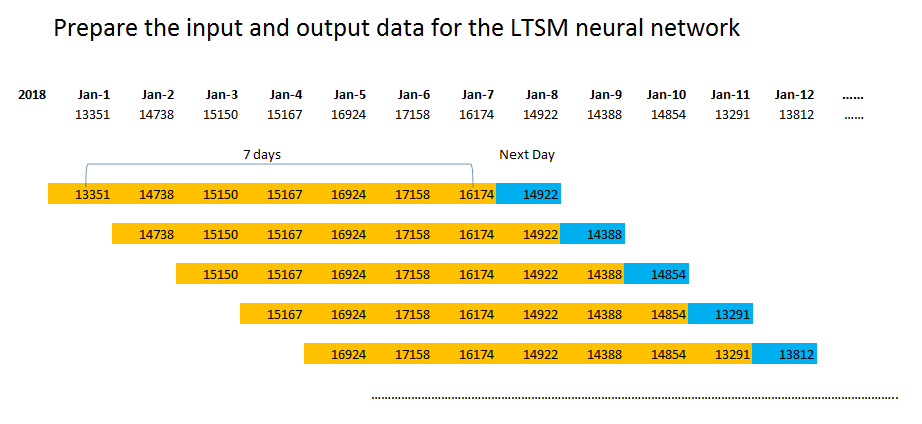

In [ ]:
# choose a number of time steps
n_steps = 7

# split into training samples
x_train, y_train = split_sequence(train_seq, n_steps)

# reshape from [samples, timesteps] to [samples, timesteps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], n_features)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)


In [ ]:
index = 0
print(x_train[index])
print('--->', y_train[index])

In [ ]:
# define the LTSM model
# The number of hidden neurons in LSTM does not directly relate to the timestep 
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()
# The lstm (LSTM) Param # = g * [h(h+i) + h]
# where g is number of gates and LSTM = 4
# h = no. of LSTM hidden neurons
# i = the dimension of input (feature)
# 4 * (32 (32 + 1) + 32) = 4352

In [ ]:
# fit model
history = model.fit(x_train, y_train, epochs=20)

# Plot the loss
loss = history.history['loss']
epoch = range(1, len(loss) + 1)

plt.plot(epoch, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.show()

In [ ]:
# predict the next day
index = train_size
x_seq, yhat, y = getPrediction(model, raw_seq, index, n_steps, n_features)

predicted = yhat[0][0]
actual = y
error = actual - predicted
errorP = abs(error) / predicted

print(x_seq, "\n")
print("Predicted:", predicted)
print("Actual:", actual)
print("Error:", error)
print("Error%:", roundNum(errorP, 4)*100)

In [ ]:
# Predict the rest of the series and comparing to the test set
# Each prediction is based on the "actual" observation from the past days
# Another way is to use multi-step ahead output or
# use the predicted values as new observations to further predict the rest of the series

predictedList = []
actualList = []

for i in range(train_size, data_size):
  x_seq, yhat, y = getPrediction(model, raw_seq, i, n_steps, n_features)
  predictedList.append(yhat[0][0])
  actualList.append(y)

# plot the result
plt.figure(figsize=(SCREEN_X, SCREEN_Y))
plt.plot(predictedList, label="Predicted")
plt.plot(actualList, label="Actual")
plt.legend()

In [ ]:
# look at the individual predictions
lstmError = []
lstmErrorP = []
for i in range(len(predictedList)):
  error = actualList[i]-predictedList[i]
  absError = abs(error)
  errorP = absError/actualList[i]
  lstmError.append(absError)
  lstmErrorP.append(errorP)

  print("Predicted:", roundNum(predictedList[i]),
       "  Actual:", roundNum(actualList[i]),
       "  Error:", roundNum(error), 
        "->", roundNum(errorP), sep='')

print("--------------------------------------")  
print("Error: Total=",roundNum(sum(lstmError)), " Average=",roundNum(stats.mean(lstmError)), " Min=",roundNum(min(lstmError)), " Max=",roundNum(max(lstmError)), sep='')
print("Error Ratio: Average=",roundNum(stats.mean(lstmErrorP)), " Min=",roundNum(min(lstmErrorP)), " Max=",roundNum(max(lstmErrorP)), sep='')

In [ ]:
# Baseline comparison: predict the next day close as the same as today's close
basePredictedList = []
baseActualList = []

for i in range(train_size, data_size):
  x_seq, yhat, y = getBasePrediction(raw_seq, i, n_steps)
  basePredictedList.append(yhat)
  baseActualList.append(y)


# look at the individual predictions
baseError = []
baseErrorP = []
for i in range(len(basePredictedList)):
  error = baseActualList[i]-basePredictedList[i]
  absError = abs(error)
  errorP = absError/baseActualList[i]
  baseError.append(absError)
  baseErrorP.append(errorP)

  print("Predicted:", roundNum(basePredictedList[i]),
       "  Actual:", roundNum(baseActualList[i]),
       "  Error:", roundNum(error), 
        "->", roundNum(errorP), sep='')

print("--------------------------------------")  
print("Error: Total=",roundNum(sum(baseError)), " Average=",roundNum(stats.mean(baseError)), " Min=",roundNum(min(baseError)), " Max=",roundNum(max(baseError)), sep='')
print("Error Ratio: Average=",roundNum(stats.mean(baseErrorP)), " Min=",roundNum(min(baseErrorP)), " Max=",roundNum(max(baseErrorP)), sep='')


In [ ]:
# plot base result
plt.figure(figsize=(SCREEN_X, SCREEN_Y))
plt.plot(basePredictedList, label="Predicted")
plt.plot(baseActualList, label="Actual")
plt.legend()

In [ ]:
# plot all results
plt.figure(figsize=(SCREEN_X, SCREEN_Y))
plt.plot(predictedList, label="LSTM")
plt.plot(basePredictedList, label="Base")
plt.plot(baseActualList, label="Actual")
plt.legend()